<h1 style="text-align: center;">Introduction </h1>    
<h2 style="text-align: left;">Purpose:</h2>  
The main purpose is to find ligand and receptor pair that happened between ednothelial cell and endothelial cell (homotypic communication) and showed a significant decreasing pattern with age.
<h2 style="text-align: left;">Approach:</h2>  

1 Get the cell to cell communication results from package liana (published tool)   
2 Count the first 100 homotypic communication pairs for each age group    
3 Get the union set of paris across all ages.   
4 Get the rank of the union set pairs for each age stage    
5 Using the rank to perform linear regression and set P value threshold    
6 Draw the final graph    
The ideology is very simliar to kruskal wallis test (statistic)    

## Sample info
Sample data came from cellxgene dataset, species: mouse

In [92]:
import scanpy as sc
import pandas as pd
import liana as li
from mousipy import translate
from liana.mt import rank_aggregate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [6.8, 5.5]
plt.rcParams['figure.dpi'] = 110
import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import re


class stage:
    def __init__(self,adata,stage_name,stage_column):
        self.stage_name=stage_name
        self.adata=adata[adata.obs[stage_column].isin([stage_name])]
        
    def run_ccc(self):
        self.result=rank_aggregate.__call__(
                                    self.adata,
                                    groupby='free_annotation',
                                    resource_name='consensus',
                                    expr_prop= 0.1,
                                    min_cells = 5,
                                    base = 2.718281828459045,
                                    aggregate_method='rra',
                                    return_all_lrs = False,
                                    consensus_opts=None,
                                    use_raw = False,
                                    layer = None,
                                    de_method='t-test',
                                    verbose = False,
                                    n_perms = 1000,
                                    seed = 1337,
                                    resource = None,
                                    inplace=False,
                                )
        self.result=self.result.reset_index()
        self.result=self.result.drop('index',axis=1)
        self.adata.uns['liana_res']=self.result
        
    def run_pca_ccc(self,type_name):
        self.type_index=self.result[self.result.apply(lambda x: type_name in x['source'] or type_name in x['target'],
                                                      axis=1)].index.to_list()
        self.ccc_adata=sc.AnnData(self.result.drop(['source', 'target', 'ligand_complex', 'receptor_complex'],axis=1))
        sc.tl.pca(self.ccc_adata, svd_solver='arpack')
        sc.pp.neighbors(self.ccc_adata, n_neighbors=10, n_pcs=5)
        sc.tl.leiden(self.ccc_adata, resolution = 0.25)
        sc.tl.umap(self.ccc_adata)
        self.type_index=[str(x) for x in self.type_index]
        self.ccc_adata.obs[type_name]=None
        self.ccc_adata.obs.loc[self.type_index,type_name]=type_name
        self.ccc_adata.obs[type_name]=self.ccc_adata.obs[type_name].astype('category')
        
        return self.ccc_adata    

def add_combination(data):
    data['cell']=data['source']+','+data['target']
    data['pair']=data['ligand_complex']+','+data['receptor_complex']
    data['single result']=data['cell']+','+data['pair']
    return data

def get_cutoff(data, source, target):
    #x=data[(data['cell'].isin([source+','+target])) & (data['cellchat_pvals']<0.05)].head(threshold)
    x=data[(data['cell'].isin([source+','+target])) & (data['cellchat_pvals']<0.05)]
    return x

def get_all_pairs(all_stage__result_list,source, target):
    union_list=[]
    for x in all_stage__result_list:
        z=get_cutoff(x,source, target)
        z=z['single result']
        union_list=list(set(union_list).union(set(z)))
    print(len(union_list))
    intersection_list=union_list
    for x in all_stage__result_list:
        z=x[x['single result'].isin(union_list)]['single result'].to_list()
        intersection_list=list(set(intersection_list).intersection(set(z)))
    print(len(intersection_list))
    return intersection_list


def get_final_trend(stages_dict,all_pairs, rank_column):
    final=[]
    for z in stages_dict:
        z=stages_dict[z].result[stages_dict[z].result['single result'].isin(all_pairs)][['single result',
            rank_column]].set_index('single result').rename(columns={
            rank_column:z})
        final.append(z)
    final=pd.concat(final,axis=1)
        
    return final


def get_subset_rank(final):
    subset_column=[]
    z=final.columns.to_list()
    final=final.reset_index()
    for x in z:
        final=final.sort_values(x).reset_index(drop=True).reset_index(names=x+' subset')
        subset_column.append(x+' subset')
    final=final.set_index('single result')
    final_subset=final[subset_column]
    final_subset.columns=final_subset.columns.str.replace("m subset", "").astype('int')
    final_subset=final_subset.transpose().sort_index().transpose()
    return final_subset

def batch_processing(a, stage_column,running_ccc=False):
    stages_dict={}
    for s in a.obs[stage_column].cat.categories:
        stages_dict[s]=stage(a,s,stage_column)
    if running_ccc:
        for key in stages_dict:
            stages_dict[key].run_ccc()
            stages_dict[key].result.to_csv(key+'.csv')
    return stages_dict

def integrate(stages_dict,source, target, rank_column):
    for key in stages_dict:
        stages_dict[key].result=add_combination(stages_dict[key].result)

    all_list=[]
    for key in stages_dict:
        all_list.append(stages_dict[key].result)
    all_pairs=get_all_pairs(all_list,source,target)

    final=get_final_trend(stages_dict,all_pairs,rank_column)
    final_subset=get_subset_rank(final)
    return final_subset


def linear_reg(row,x_axis):
    model=stats.linregress(x_axis,row)
    return model.slope, model.rvalue**2 ,model.pvalue


def analysis(final_subset,rank_column,p_threshold=0.05,slope_threshold=-0.1,save_doc=True):
    subset_linear=pd.DataFrame(final_subset.apply(lambda row: linear_reg(row, final_subset.columns.to_list()),
            axis=1,result_type='expand')
             ).rename(columns={0:'slope',1:'r2',2:'p_value'})
    filtered_subset=subset_linear[(subset_linear['p_value']<p_threshold) & (subset_linear['slope']<slope_threshold)].index
    plt.plot(final_subset.loc[filtered_subset].transpose(),label=final_subset.loc[filtered_subset].index.to_list())
    plt.xticks(final_subset.columns.to_list(),labels=[str(x)+'m' for x in final_subset.columns.to_list()])
    plt.legend(loc='upper right', bbox_to_anchor=(1.55,1))
    plt.xlabel('age',fontsize=12)
    plt.ylabel('subset_rank'+'('+rank_column+')')
    plt.title('Cell to Cell communication pairs')
    if p_threshold>0.05:
        plt.text(-4,2,'p_threshold: '+str(p_threshold))
    if save_doc:
        plt.savefig('result.pdf',bbox_inches='tight')
        final_subset.to_csv('final_subset.csv')
        subset_linear.to_csv('subset_linear.csv')
    pass

In [118]:
a=sc.read_h5ad('./heart2/heart2.h5ad')
a.var['feature_name']=a.var['feature_name'].astype('string')
a.var=a.var.set_index('feature_name')

In [119]:
a=translate(a)

100%|██████████| 17985/17985 [00:20<00:00, 856.93it/s]


Found direct orthologs for 14969 genes.
Found multiple orthologs for 486 genes.
Found no orthologs for 2500 genes.
Found no index in biomart for 30 genes.


100%|██████████| 486/486 [02:04<00:00,  3.90it/s]
/Users/boyongwei/anaconda3/envs/pymysql/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [120]:
a.var=a.var.drop(a.var.columns,axis=1)

a.write_h5ad('translated.h5ad')

In [122]:
stages_dict=batch_processing(a,'age',running_ccc=True)

/Users/boyongwei/anaconda3/envs/pymysql/lib/python3.9/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/boyongwei/anaconda3/envs/pymysql/lib/python3.9/site-packages/liana/method/sc/_rank_aggregate.py:158: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/Users/boyongwei/anaconda3/envs/pymysql/lib/python3.9/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/boyongwei/anaconda3/envs/pymysql/lib/python3.9/site-packages/liana/method/sc/_rank_aggregate.py:158: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/Users/boyongwei/anaconda3/envs/pymysql/lib/python3.9/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing

In [123]:
a.obs['free_annotation'].cat.categories

Index(['atrial cardiomyocyte', 'cardiac mast cell', 'cardiac neuron',
       'coronary vascular endothelial cell', 'endocardial endothelial cells',
       'fibroblast', 'leukocyte', 'nan', 'red blood cell',
       'smooth muscle cell'],
      dtype='object')

In [124]:
final_subset=integrate(stages_dict,'coronary vascular endothelial cell','coronary vascular endothelial cell','magnitude_rank')

46
39


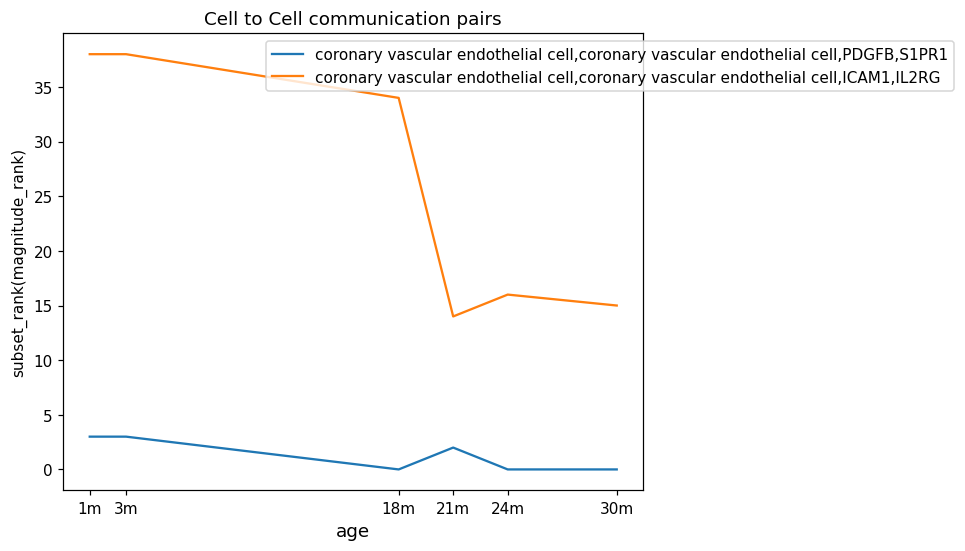

In [125]:
analysis(final_subset,'magnitude_rank')